# Word Embedding Visualizations.

Name: Anthony Kevin Oktavius

Here, we'll experiment with various embedding layer, with these following techniques.

* TF-IDF
* Count Vectorizer
* Word2Vec
* Neural network embedding layer.

As time passes, I'll try to add various  techniques. We also use dimensionality reduction technique to reduce the dimension of each layers, so we can visualize the relationshop between each words with matplotlib.

Library Import

In [18]:
import numpy as np
import zipfile
import gc
import pickle
import cv2
import math
import warnings
import random
import string
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
# import torchmetrics
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import pickle
import collections
import nltk

# import pytorch_lightning as pl
import imutils
import zipfile

from nltk.corpus import words, stopwords
from wordcloud import WordCloud
from PIL import Image
from torch.utils.data import Dataset
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from google.colab.patches import cv2_imshow

nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

Dataset Loading with OpinRank dataset.

In [5]:
! wget https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz

--2023-09-29 13:57:25--  https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443254787 (423M) [application/x-gzip]
Saving to: ‘enron_mail_20150507.tar.gz’

enron_mail_20150507 100%[===================>] 422.72M  1.56MB/s    in 4m 32s  

2023-09-29 14:01:58 (1.56 MB/s) - ‘enron_mail_20150507.tar.gz’ saved [443254787/443254787]



Unzip the dataset in tar file format.

In [6]:
! tar -xzf /content/enron_mail_20150507.tar.gz

## Data Preparation

Gather all of the email paths from all-documents folder.

In [7]:
root_path = "maildir/"
email_paths_from_all_documents_folder = glob.glob(os.path.join(root_path, "*/all_documents/*."))
print(email_paths_from_all_documents_folder[:10])

['maildir/ruscitti-k/all_documents/224.', 'maildir/ruscitti-k/all_documents/133.', 'maildir/ruscitti-k/all_documents/220.', 'maildir/ruscitti-k/all_documents/310.', 'maildir/ruscitti-k/all_documents/325.', 'maildir/ruscitti-k/all_documents/16.', 'maildir/ruscitti-k/all_documents/348.', 'maildir/ruscitti-k/all_documents/148.', 'maildir/ruscitti-k/all_documents/72.', 'maildir/ruscitti-k/all_documents/296.']


Get body email data, after X-Filename.

In [8]:
print("Sample Email data: ")

def read_file(path):
  return open(path, "r", errors='ignore')

def get_removed_components_email_text(text):
  texts_per_line = text.split("\n")

  full_email_text_per_line = []

  email_components = [
    "Message-ID: ", "Date: ", "From: ",
    "To: ", "Subject: ", "Mime-Version: ",
    "Content-Type: ", "Content-Transfer-Encoding: ", "X-From: ",
    "X-cc: ", "X-bcc: ", "X-Folder: ", "X-FileName: ",
    "X-Origin: ", "X-Filename: ", "cc: ", "@enron.com",
  ]
  NOT_FOUND = -1

  for text_per_line in text.split("\n"):
    is_exist_component = False
    for component in email_components:
      if text_per_line.find(component) != NOT_FOUND:
        is_exist_component = True
        break
    if is_exist_component == False:
      full_email_text_per_line.append(text_per_line)

  return " ".join(full_email_text_per_line)

sample_file = read_file(email_paths_from_all_documents_folder[0])
sample_body_email_data = get_removed_components_email_text(sample_file.read())

print(sample_body_email_data)

Sample Email data: 
 The attached file contains our latest daily volume requirements for 3/14 thru 3/16.           Doug Kinney Ph:  703-561-6339 Fax:  703-561-7317   - 03-14-00 Daily VolsAM.xls


Putting it all together

In [20]:
def get_dataset():
  root_path = "maildir/"
  email_paths_from_all_documents_folder = glob.glob(os.path.join(root_path, "*/all_documents/*."))

  dataset = []

  for email_path in email_paths_from_all_documents_folder:
    file_ = read_file(email_path)
    email_body = get_removed_components_email_text(file_.read())
    dataset.append(email_body)

  return dataset

dataset = get_dataset()
print(f"Number of data: {len(dataset)}")
dataset[:10]

Number of data: 128103


[' The attached file contains our latest daily volume requirements for 3/14 thru 3/16.           Doug Kinney Ph:  703-561-6339 Fax:  703-561-7317   - 03-14-00 Daily VolsAM.xls',
 " Great to hear you'll be back soon.  Get me a call when you get back in the  states and tell that Fathead I said hi.  Kevin",
 ' Kevin,  How\'s things?  Been a while since we talked.  Hope your jobs are going well and your wedding plans are proceeding smoothly.  Did you get my e-mail about running into Mary Eyre in the gym in San Mateo? Spooky.  I\'ve seen her a couple more times but I haven\'t spoken to her; I get in the "properly pumped" zone.  Turns out there are a lot of classmates on the peninsula - David Park, Frank Knifsend, Mary, and James Regan come to mind immediately.  No real news here.  We haven\'t broken anything in the house in a while, so either we\'re getting luckier or we\'re due.  Both jobs are very busy right now so the weekends are for recuperating.  This weekend, of course, will be for w

Remove Punctuations from the dataset.

In [21]:
def get_removed_duplicated_space_in_string(my_string):
    return " ".join(my_string.split())

def get_erased_punctuations(text):
    list_of_punctuations = string.punctuation + "\‘="
    final_text = text

    for punc in list_of_punctuations:
      final_text = final_text.replace(punc, "")

    final_text = get_removed_duplicated_space_in_string(final_text)

    return final_text

erased_punctuations_dataset = []

for datum in dataset:
  erased_punctuations_datum = get_erased_punctuations(datum)
  erased_punctuations_dataset.append(erased_punctuations_datum)

erased_punctuations_dataset[:10]

['The attached file contains our latest daily volume requirements for 314 thru 316 Doug Kinney Ph 7035616339 Fax 7035617317 031400 Daily VolsAMxls',
 'Great to hear youll be back soon Get me a call when you get back in the states and tell that Fathead I said hi Kevin',
 'Kevin Hows things Been a while since we talked Hope your jobs are going well and your wedding plans are proceeding smoothly Did you get my email about running into Mary Eyre in the gym in San Mateo Spooky Ive seen her a couple more times but I havent spoken to her I get in the properly pumped zone Turns out there are a lot of classmates on the peninsula David Park Frank Knifsend Mary and James Regan come to mind immediately No real news here We havent broken anything in the house in a while so either were getting luckier or were due Both jobs are very busy right now so the weekends are for recuperating This weekend of course will be for watching basketball Hi to Lisa let us know how youre doing Regards Tim Sarhatt Sr T

Remove integers from dataset.

In [22]:
def erase_all_digits_from_sentence(sentence):
    digits = string.digits
    table = str.maketrans('', '', digits)
    new_string = sentence.translate(table)
    return new_string

erased_all_digits_dataset = []

for datum in erased_punctuations_dataset:
  all_digits_erased_datum = erase_all_digits_from_sentence(datum)
  erased_all_digits_dataset.append(all_digits_erased_datum)

erased_all_digits_dataset[:10]

['The attached file contains our latest daily volume requirements for  thru  Doug Kinney Ph  Fax   Daily VolsAMxls',
 'Great to hear youll be back soon Get me a call when you get back in the states and tell that Fathead I said hi Kevin',
 'Kevin Hows things Been a while since we talked Hope your jobs are going well and your wedding plans are proceeding smoothly Did you get my email about running into Mary Eyre in the gym in San Mateo Spooky Ive seen her a couple more times but I havent spoken to her I get in the properly pumped zone Turns out there are a lot of classmates on the peninsula David Park Frank Knifsend Mary and James Regan come to mind immediately No real news here We havent broken anything in the house in a while so either were getting luckier or were due Both jobs are very busy right now so the weekends are for recuperating This weekend of course will be for watching basketball Hi to Lisa let us know how youre doing Regards Tim Sarhatt Sr Treasury Analyst Adaptive Broadba

Lowercase All Letters.

In [23]:
def lowercase_letters(sentence):
    return sentence.lower()

lowecase_text_dataset = []

for datum in erased_all_digits_dataset:
  lowercase_letters_datum = lowercase_letters(datum)
  lowecase_text_dataset.append(lowercase_letters_datum)

lowecase_text_dataset[:10]

['the attached file contains our latest daily volume requirements for  thru  doug kinney ph  fax   daily volsamxls',
 'great to hear youll be back soon get me a call when you get back in the states and tell that fathead i said hi kevin',
 'kevin hows things been a while since we talked hope your jobs are going well and your wedding plans are proceeding smoothly did you get my email about running into mary eyre in the gym in san mateo spooky ive seen her a couple more times but i havent spoken to her i get in the properly pumped zone turns out there are a lot of classmates on the peninsula david park frank knifsend mary and james regan come to mind immediately no real news here we havent broken anything in the house in a while so either were getting luckier or were due both jobs are very busy right now so the weekends are for recuperating this weekend of course will be for watching basketball hi to lisa let us know how youre doing regards tim sarhatt sr treasury analyst adaptive broadba

Remove stopwords from the dataset.

In [26]:
def get_stopwords_from_nltk(language = 'english'):
  nltk.download('stopwords')
  return stopwords.words(language)

def get_stopwords_removed_sentence(sentence, list_of_stopwords = get_stopwords_from_nltk()):
  new_sentence = ""

  for word in sentence.split(" "):
    if word not in list_of_stopwords:
      new_sentence += f"{word} "

  return new_sentence

removed_stopwords_dataset = []

for datum in lowecase_text_dataset:
  removed_stopwords_datum = get_stopwords_removed_sentence(datum)
  removed_stopwords_dataset.append(removed_stopwords_datum)

removed_stopwords_dataset[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['attached file contains latest daily volume requirements  thru  doug kinney ph  fax   daily volsamxls ',
 'great hear youll back soon get call get back states tell fathead said hi kevin ',
 'kevin hows things since talked hope jobs going well wedding plans proceeding smoothly get email running mary eyre gym san mateo spooky ive seen couple times havent spoken get properly pumped zone turns lot classmates peninsula david park frank knifsend mary james regan come mind immediately real news havent broken anything house either getting luckier due jobs busy right weekends recuperating weekend course watching basketball hi lisa let us know youre regards tim sarhatt sr treasury analyst adaptive broadband tsarhattadaptivebroadbandcom   ',
 'forwarded elisabeth ruscittihlphouind   pm frank moore   pm ron r russellhlphouind elisabeth ruscittihlphouindh ouind dave gerberdingrmhouind houind kevin l davisrmhouindhouin rudy penapghouindhouind tony j votanohlphouindhou ind california dreamin accurat

Remove words that are not from the dictionary.

In [28]:
def get_words_from_corpus():
  return words.words("en")

def get_filter_english_words_dict(additional_words = []):
  eng_word_mapping_dict = dict()
  words_from_corpus = get_words_from_corpus()

  for word in words_from_corpus:
    eng_word_mapping_dict[word] = word

  for word in additional_words:
    eng_word_mapping_dict[word] = word

  return eng_word_mapping_dict

def get_filtered_sentence_from_corpus(sentence, words_from_corpus_dict):

  new_sentence = ""
  for word in sentence.split(" "):
    try:
      new_sentence += f"{words_from_corpus_dict[word]} "
    except KeyError as e:
      pass

  return new_sentence

filtered_sentence_from_corpus_dataset = []
eng_word_mapping_dict = get_filter_english_words_dict()
for datum in removed_stopwords_dataset:
  sentence = get_filtered_sentence_from_corpus(datum, eng_word_mapping_dict)
  filtered_sentence_from_corpus_dataset.append(sentence)

filtered_sentence_from_corpus_dataset[:10]

['attached file latest daily volume daily ',
 'great hear back soon get call get back tell fathead said hi ',
 'since hope going well wedding proceeding smoothly get running mary eyre gym san spooky seen couple times havent spoken get properly zone turns lot peninsula park frank mary come mind immediately real news havent broken anything house either getting due busy right weekend course watching basketball hi let us know treasury analyst adaptive ',
 'frank r l tony j accurate cartoon frank project manager reliant energy ',
 'hey good hear hope well well golden state could certainly use help gray little mouse power natural gas situation mess gas situation much worse us point long beach havent seen power significant increase bill either gas front entirely different matter bill month month usage figure one level might well paying heating oil people talk scene gas bill go fold anyway could whole lot worse guess luke st birthday party past weekend quite scene think next party say hello us

## Data Visualization

Get the latest dataset

In [29]:
preprocessed_dataset = filtered_sentence_from_corpus_dataset

Performing Word Cloud.

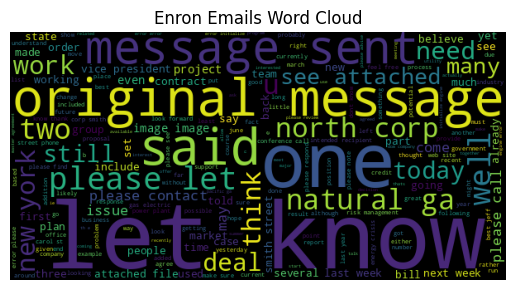

In [30]:
def visualize_word_cloud(documents, title, width, height):
    word_cloud = WordCloud(width = width, height = height, random_state = 100)
    text_from_all_documents = " ".join(documents)
    word_cloud.generate(text_from_all_documents)

    plt.title(title)
    plt.axis("off")
    plt.imshow(word_cloud)
    plt.show()

visualize_word_cloud(
  preprocessed_dataset,
  title = "Enron Emails Word Cloud",
  width = 600,
  height = 300
)

Analyze bigrams

In [31]:
flattened_words = [" ".join(preprocessed_dataset)]

bigram_count_vectorizer = CountVectorizer(
    lowercase = True,
    ngram_range = (2, 2),
)
vector_components_count_vectorizer = bigram_count_vectorizer.fit_transform(flattened_words)
feature_names = bigram_count_vectorizer.get_feature_names_out()
total_occurence_per_features = vector_components_count_vectorizer.toarray().sum(axis = 0)

print("=============Bigram Properties=============")
print(f"Vector components size: {vector_components_count_vectorizer.shape}")
print(feature_names[:10])
# print(vector_components_count_vectorizer.sum(axis = 1))
print(total_occurence_per_features.shape)
print("===========================================")

=============Bigram Properties=============
Vector components size: (1, 2407291)
['aa aa' 'aa accounting' 'aa action' 'aa ad' 'aa addition' 'aa address'
 'aa admonition' 'aa advice' 'aa advised' 'aa agency']
(2407291,)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'let know'),
  Text(1, 0, 'would like'),
  Text(2, 0, 'original message'),
  Text(3, 0, 'message sent'),
  Text(4, 0, 'please let'),
  Text(5, 0, 'natural gas'),
  Text(6, 0, 'north corp'),
  Text(7, 0, 'new york'),
  Text(8, 0, 'see attached'),
  Text(9, 0, 'please contact')])

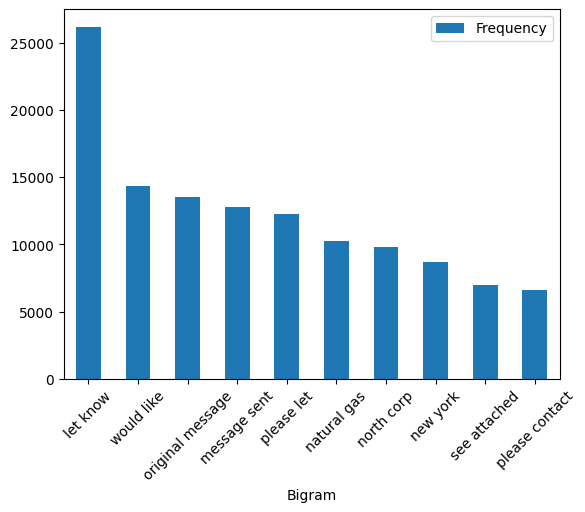

In [32]:
sorted_total_occurence_per_features = pd.DataFrame(
    {
        "Bigram": feature_names,
        "Frequency": total_occurence_per_features,
    }
).sort_values(by = "Frequency", ascending = False)

top_10_bigrams = sorted_total_occurence_per_features.nlargest(10, "Frequency")

ax = top_10_bigrams.plot(
    x = "Bigram",
    kind = "bar",
)

plt.xticks(rotation=45)